In [1]:
import MDAnalysis as mda
from MDAnalysis.analysis import dihedrals, rms
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import nglview as nv
import pandas
import math
from openmm import *

### Set parameters 

In [2]:
is_deactivate_warning = True
is_savefigs = True

sysname = 'AlanineDipeptide'
# name of PDB file
pdb_filename = "./vacuum.pdb"
# name of DCD file
output_path = './traj_data' 

traj_dcd_filename = '%s/traj.dcd' % output_path

if is_deactivate_warning :
    import warnings
    warnings.filterwarnings("ignore")    

### Load trajectory data 

In [3]:
# load the trajectory data from DCD file
u = mda.Universe(pdb_filename, traj_dcd_filename)
# load the reference configuration from the PDB file
ref = mda.Universe(pdb_filename) 

# print some information
print ('residues: ', u.residues)
print ('trajectory: ', u.trajectory)
print ('reference: ', ref.trajectory)

# display the trajectory
view = nv.show_mdanalysis(u)
print ('number of frames: %d ' % view.max_frame)
view

residues:  <ResidueGroup [<Residue ACE, 1>, <Residue ALA, 2>, <Residue NME, 3>]>
trajectory:  <DCDReader ./traj_data/traj.dcd with 100000 frames of 22 atoms>
reference:  <PDBReader ./vacuum.pdb with 1 frames of 22 atoms>
number of frames: 99999 


NGLWidget(max_frame=99999)

### Generate plots of two dihedral angles

Ramachandran plot saved to file: ././traj_data/AlanineDipeptide_Ramachandran.eps


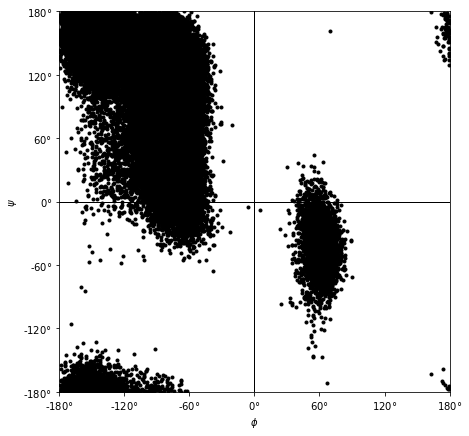

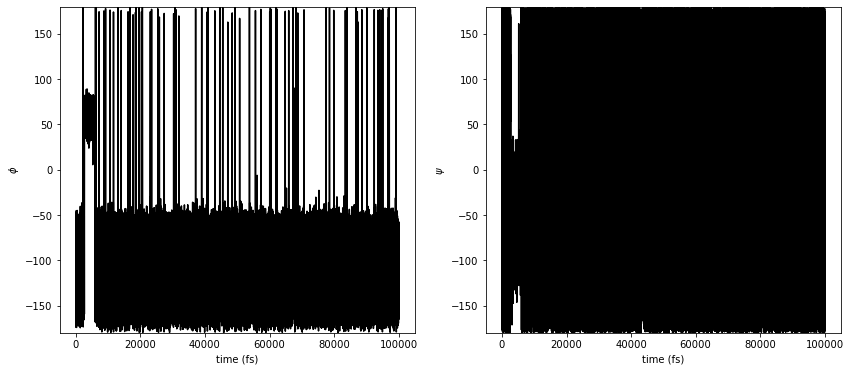

In [4]:
# generate the Ramachandran plot of two dihedral angles
#ax = plt.gca()
fig, ax = plt.subplots(figsize=(7,7))

r = dihedrals.Ramachandran(u.select_atoms('resid 2')).run()
r.plot(ax, color='black', marker='.') #, ref=True)

traj_angles = r.angles[:,0,:]

if is_savefigs :
    fig_filename_Ramachandran = './%s/%s_Ramachandran.eps' % (output_path, sysname)
    plt.savefig(fig_filename_Ramachandran)
    print ('Ramachandran plot saved to file: %s' % fig_filename_Ramachandran)
    
fig, ax = plt.subplots(1,2, figsize=(14,6))
ax[0].plot(traj_angles[:,0], 'k-')
ax[0].set_ylim([-180,180])
ax[0].set_xlabel("time (fs)")
ax[0].set_ylabel(r"$\phi$")

ax[1].plot(traj_angles[:,1], 'k-')
ax[1].set_xlabel("time (fs)")
ax[1].set_ylim([-180,180])
ax[1].set_ylabel(r"$\psi$")

plt.show()

### Plot weights

Index(['Time (ps)', 'weight'], dtype='object')

Describe:
 count    100000.000000
mean          1.000000
std           2.061150
min           0.000023
20%           0.078263
40%           0.225078
50%           0.345147
60%           0.527267
80%           1.316575
max          99.591568
Name: weight, dtype: float64

Describe:
 count    98960.000000
mean         0.872158
std          1.376943
min          0.001001
20%          0.078030
40%          0.222766
50%          0.340425
60%          0.516800
80%          1.272862
max          9.997906
Name: weight, dtype: float64


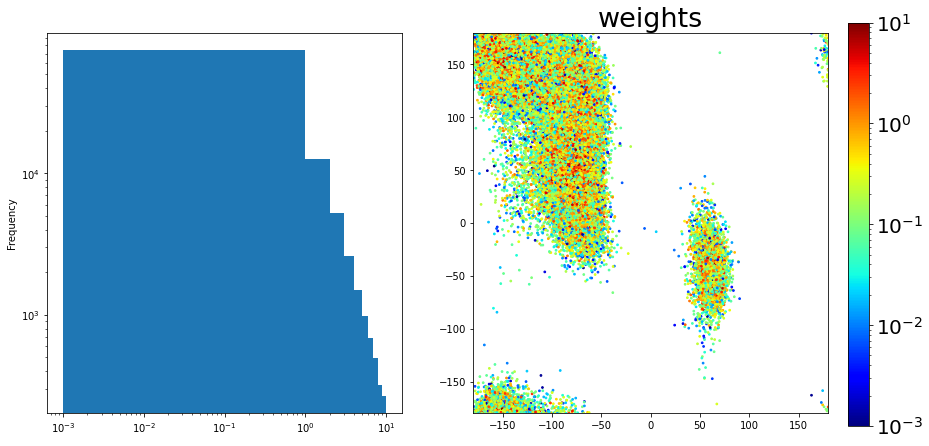

In [7]:
weight_filename = "%s/weights.csv" % output_path
weights = pandas.read_csv(weight_filename)
print (weights.columns)
print ('\nDescribe:\n', weights['weight'].describe(percentiles=[0.2, 0.4, 0.6, 0.8]))

fig, ax = plt.subplots(1,2, figsize=(14,7))

nbin=10
[vmin, vmax] = [1e-3, 1e1]
[min_weight, max_weight] = [1e-3, 1e1]

# select states according to weights
select = (weights['weight']>min_weight) & (weights['weight']<max_weight)
weights = weights[select]
print ('\nDescribe:\n', weights['weight'].describe(percentiles=[0.2, 0.4, 0.6, 0.8]))

# histogram of weights
weights['weight'].plot(kind='hist', logx=True, logy=True, ax=ax[0], bins=nbin)

# scatter plot of weights 
sc = ax[1].scatter(traj_angles[select,0], traj_angles[select,1], s=3.0, c=weights['weight'], vmin=vmin, vmax=vmax, cmap='jet', norm=matplotlib.colors.LogNorm())

ax[1].set_title(f'weights', fontsize=27)
ax[1].set_xlim([-180,180])
ax[1].set_ylim([-180,180])

#ax.set_xticks([-3, -2, -1, 0, 1, 2, 3])
#ax.set_yticks([-3, -2, -1, 0, 1, 2, 3])
cax = fig.add_axes([0.92, 0.10, .02, 0.80])
cbar = fig.colorbar(sc, cax=cax)
cbar.ax.tick_params(labelsize=20)

plt.show()

### RMSD plot

In [ ]:
# select atoms for RMSD computation below 
selector = 'name N or name CA or name C'
# compute RMSD of the trajectory wrt the reference configuration
R = rms.RMSD(u, ref, select=selector)          
R.run()
# get the RMSD result
rmsd = R.results.rmsd.T   # transpose makes it easier for plotting

fig, ax = plt.subplots(figsize=(12,6))

plt.plot(rmsd[0,:], rmsd[2,:], 'k-')
plt.xlabel("time (fs)")
plt.ylabel(r"RMSD ($\AA$)")

if is_savefigs :
    fig_filename_rmsd = './%s/%s_rmsd.eps' % (output_path, sysname) 
    plt.savefig(fig_filename_rmsd)    
    print ('RMSD plot saved to file: %s' % fig_filename_rmsd)

### Plot state data from CSV file

In [ ]:
csv_filename = "%s/state_data.csv" % output_path
csv_col_idx = 1

df1 = pandas.read_csv(csv_filename)
print (df1.describe())

fig, ax = plt.subplots(figsize=(8,6))
df1.plot(kind='line', ax=ax, x='#"Time (ps)"', y=df1.columns[csv_col_idx])

if is_savefigs :
    # to get rid of warning when saving figure to eps format
    ax.set_rasterized(True)
    fig_filename= './%s/%s_csv%d.eps' % (output_path, sysname, csv_col_idx) 
    plt.savefig(fig_filename)    
    print ('Potential Energy saved to file: %s' % fig_filename)

fig, ax = plt.subplots(figsize=(8,6))
sc = ax.scatter(traj_angles[:,0], traj_angles[:,1], s=3.0, c=df1[df1.columns[csv_col_idx]], cmap='jet')

ax.set_title(f'{df1.columns[csv_col_idx]}', fontsize=27)
#ax.set_xticks([-3, -2, -1, 0, 1, 2, 3])
#ax.set_yticks([-3, -2, -1, 0, 1, 2, 3])

cax = fig.add_axes([0.92, 0.10, .02, 0.80])
cbar = fig.colorbar(sc, cax=cax)
cbar.ax.tick_params(labelsize=20)
plt.show()

### Check trained model on data

In [ ]:
num_scatter_states = 10000
# read configuration parameters
args = Args()

model_file = 'trained_cv_scripted.pt'

universe = mda.Universe(args.pdb_filename, args.traj_dcd_filename)

print ('====================Trajectory Info===================')

# load the trajectory data from DCD file
traj_obj = WeightedTrajectory(universe, args.traj_weight_filename, args.cutoff_weight_min, args.cutoff_weight_max)

print ('==============Features===================\n')
print ('Features file: {}'.format(args.feature_file)) 

print ('\nFeatures for histogram: \n')
# read features for histogram plot
feature_reader = FeatureFileReader(args.feature_file, 'Histogram', universe)
feature_list = feature_reader.read()

if len(feature_list) == 0 : 
    print ("Warning: no feature found! \n") 
    histogram_feature_mapper = None
else :
    histogram_feature_mapper = ann.FeatureLayer(feature_list, use_angle_value=True)
    print (histogram_feature_mapper.get_feature_info())
    # make sure each feature is one-dimensional
    assert histogram_feature_mapper.output_dimension() == len(feature_list), "Features for histogram are incorrect, output of each feature must be one-dimensional!" 

    histogram_feature = self.histogram_feature_mapper(torch.tensor(traj_obj.trajectory)).detach().numpy()
    feature_names = self.histogram_feature_mapper.get_feature_info()['name']
    df = pd.DataFrame(data=histogram_feature, columns=feature_names) 

    df.hist(figsize=(5,5))

print ('\nFeatures for ouptut: \n')
# features to define a 2d space for output
feature_reader = FeatureFileReader(args.feature_file, 'Output', universe) 
feature_list= feature_reader.read()
if len(feature_list) == 2 :
    output_feature_mapper = ann.FeatureLayer(feature_list, use_angle_value=True)
    if output_feature_mapper.output_dimension() == 2 : # use it only if it is 2D
        print (output_feature_mapper.get_feature_info())
    else :
        print (f'\nOutput feature mapper set to None, since 2d feature required for output.')
        output_feature_mapper = None
else :
    output_feature_mapper = None

if output_feature_mapper :
    model = torch.jit.load(model_file)
    
    output_features = output_feature_mapper(torch.tensor(traj_obj.trajectory)).detach().numpy()

    index = np.random.choice(np.arange(feature_traj.shape[0], dtype=int), num_scatter_states, replace=False)

    X = torch.tensor(traj_obj.trajectory)[index,:]
    feature_data = output_features[index,:]
    cv_vals = model(X) 

    k = cv_vals.size(1)

    for idx in range(k) :
        fig, ax = plt.subplots()
        sc = ax.scatter(feature_data[:,0], feature_data[:,1], s=2.0, c=cv_vals[:,idx].detach().numpy(), cmap='jet')

        ax.set_title(f'{idx+1}th dimension', fontsize=27)
        ax.set_xlabel(r'{}'.format(output_feature_mapper.get_feature(0).get_name()), fontsize=25, labelpad=3, rotation=0)
        ax.set_xticks([-3, -2, -1, 0, 1, 2, 3])
        ax.set_yticks([-3, -2, -1, 0, 1, 2, 3])
        ax.set_ylabel(r'{}'.format(output_feature_mapper.get_feature(0).get_name()), fontsize=25, labelpad=-10, rotation=0)

        cax = fig.add_axes([0.92, 0.10, .02, 0.80])
        cbar = fig.colorbar(sc, cax=cax)
        cbar.ax.tick_params(labelsize=20)
